# Gene4Denovo TNT motif analysis in 2-5 bp deletions

In [1]:
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyfaidx import Fasta
from utils.utils import read_rpt_files, df_to_group_counts
from utils.utils import tnt_compliance_from_row
from utils.region_sampling import random_seqs_from_bed
from region_finder.bed_parser import BedParser
from region_finder.interval_sampler import IntervalSampler

%matplotlib inline

sns.set_context("talk")
sns.set_style('darkgrid')

out_dir = "outputs/tnt_2to5bp_del_sampling"
os.makedirs(out_dir, exist_ok=True)

In [2]:
from scipy.stats import fisher_exact
from random import randint
from collections import defaultdict
 
count_cols = ['TNT_compliant', 'variant_length', 'repeat_type']


def sample_from_genome(del_counts, genome_df, index_column='Count'):
    '''
    Randomly sample from genomewide repeat counts a set of repeats of matching
    number for each repeat type, deletion length and repeat length in the given
    series of deletion value counts.
    
    Returns a dataframe of counts for variant lengths, repeat types, and TNT
    compliance.
 
    Args:
        del_counts (pandas.Series):
            Output of:
            
                df.value_counts(['variant_length', 'repeat_length', 'repeat_type'])
            
            where df is a dataframe of observed 2bp or longer deletions.

        genome_df (pandas.DataFrame):
            Genome wide repeat counts (as generated by read_rpt_counts
            function).

        index_column (str):
            Debugging only. Column name of to use as an index for sampling from
            genome_df. For example, if you want to randomly sample based on the
            length of repeats in each category, use the 'total_bp' column, while
            if you want to randomly sample based on number of observed repeats
            in a given category use 'Count'. Because we are sampling within
            categories of the same length, these should be equivelant.

    '''
    g_smpl = defaultdict(list)
    for (del_len, rpt_len, rpt_type), cnt in zip(del_counts.index, del_counts):
        del_len = int(del_len)
        rpt_len = int(rpt_len)
        tmp_df = genome_df[(genome_df.repeat_type == rpt_type) &
                           (genome_df.variant_length == del_len) &
                           (genome_df.repeat_length == rpt_len)]
        total = tmp_df[index_column].sum() - 1
        cidx = tmp_df[index_column].cumsum()
        for i in range(cnt):
            try:
                r_int = randint(0, total)
            except ValueError:
                raise ValueError("Failed index lookup for {}:{}:{}".format(rpt_type, del_len, rpt_len))
            i = cidx.searchsorted(r_int, side='right')
            rpt_seq = tmp_df.repeat_unit.values[i]
            if rpt_type == 'Imperfect':
                # repeated sequence is the microhomology unit if Imperfect repeat
                mh_len = rpt_len - del_len
                rpt_seq = rpt_seq[:mh_len] 
            tnt_compliant = 'A' in rpt_seq or 'T' in rpt_seq
            g_smpl['TNT_compliant'].append(tnt_compliant)
            g_smpl['variant_length'].append(del_len)
            g_smpl['repeat_type'].append(rpt_type)
    g_smpl = pd.DataFrame.from_dict(g_smpl)
    g_counts = g_smpl.groupby(count_cols)[count_cols[0]].count().to_frame()
    g_counts.columns = ['Count']
    return g_counts.reset_index()


def resample_from_genome(del_df, genome_df, n=100, cohort_name='Deletions',
                         index_column='Count', palette=None):
    '''
    Perform bootstrap sampling of genomewide repeat counts. Each sampling gives
    a set of repeats of matching the number of each repeat type, deletion length
    and repeat length in the given deletion dataframe.
    
    Returns a dataframe of counts for variant lengths, repeat types, and TNT
    compliance for genome and deletion dataframe.
    
    Args:
        del_df (pandas.DataFrame):
            dataframe of observed deletions
        
        genome_df (pandas.DataFrame):
            Genome wide repeat counts (as generated by read_rpt_counts
            function).

        n (int):
            Number of bootstrap samplings to perform.

        cohort_name (str):
            Name to assign deletions observed in del_df.


        index_column (str):
            Debugging only. Column name of to use as an index for sampling from
            genome_df. For example, if you want to randomly sample based on the
            length of repeats in each category, use the 'total_bp' column, while
            if you want to randomly sample based on number of observed repeats
            in a given category use 'Count'. Because we are sampling within
            categories of the same length, these should be equivelant.

        palette (str):
            palette name (as recognised by Seaborn) to use for barplots.
            
    '''
    sampling_counts = pd.DataFrame()
    mask = (del_df.variant_length <= 5) & (del_df.repeat_type != 'No repeat')
    del_rpt_counts = del_df[mask].value_counts(
        ['variant_length', 'repeat_length', 'repeat_type'])
    for i in range(n):
        sampling_counts = sampling_counts.append(
            sample_from_genome(del_rpt_counts, genome_df, index_column))
    sampling_counts['Cohort'] = 'Genome'
    del_counts = del_df[mask].groupby(count_cols)[count_cols[0]].count().to_frame()
    del_counts.columns = ['Count']
    del_counts.reset_index(inplace=True)
    del_counts['Cohort'] = cohort_name
    sampling_counts = sampling_counts.append(del_counts)
    sns.catplot(data=sampling_counts,
                kind='bar',
                row='variant_length',
                col='repeat_type',
                x='Cohort',
                y='Count',
                sharex=False,
                sharey=False,
                ci='sd',
                aspect=1.5,
                palette=palette,
                hue='TNT_compliant',
                hue_order=[True, False])
    cohort_tnt_counts = sampling_counts.groupby(
        ['Cohort', 'TNT_compliant', 'repeat_type']).mean().reset_index()
    for rpt_type in sampling_counts.repeat_type.unique():
        for rpt_len in sorted(sampling_counts.variant_length.unique()):
            mask = (sampling_counts.variant_length == rpt_len) & (
                    sampling_counts.repeat_type == rpt_type)
            tmp_df = sampling_counts[mask].groupby(
                ['Cohort', 'TNT_compliant', 'repeat_type']).mean()
            for cohort in sampling_counts.Cohort.unique():
                for tnt in [True, False]:
                    if (cohort, tnt, rpt_type) not in tmp_df.index:
                        append = pd.DataFrame(index=[(cohort, tnt, rpt_type)],
                                              columns=['variant_length', 'Count'],
                                              data=[[rpt_len, 0.0] ])
                        tmp_df = tmp_df.append(append)
            tmp_df = tmp_df.reset_index()
    return sampling_counts

## Retrieve all deletions 2bp or longer from Gene4Denovo

In [3]:
g4d_indels = pd.read_csv(
    "data/gene4denovo/gene4denovo_indels.csv",
    dtype={'chrom': str, 'pos': int})
g4d_deletions = g4d_indels[(g4d_indels.variant_type == 'Del') &
                           (g4d_indels.variant_length > 1)].copy()
g4d_deletions['TNT_compliant'] = g4d_deletions.apply(tnt_compliance_from_row,
                                                     axis=1)
g4d_deletions.head()

chrom        pos  qual    ref alt  n_alleles variant_type repeat_type  \
0      1  217847741   NaN   TAGG   T          2          Del     Perfect   
1      2  164875949   NaN  TTTTA   T          2          Del     Perfect   
2     11  106845486   NaN  CAGAG   C          2          Del     Perfect   
9     12   51860452   NaN  GCAAT   G          2          Del   Imperfect   
11    13  103836884   NaN    CTG   C          2          Del     Perfect   

   repeat_unit  repeat_length  \
0          AGG              9   
1         TTTA              8   
2         AGAG              8   
9           CA              6   
11          TG              6   

                                             sequence  variant_length  \
0   gatttttcttggtcgttttgcagggattatAGGaggaggtgcctca...               3   
1   attgtatttatagcacccatttatgctttattttttatttTTTAtt...               4   
2   atgtgttacatttttagagaagataaagcaacactctgacAGAGag...               4   
9   aagaagcatccatgcctgatgaatatctgttgtagatgtgCAATca...               4   
11         gtgtgcttgggagttttctcTGtgtgttttgtgtttacaagg               2   

   cosmic_class  transcribed transcribed_strand Simple_Categorization  \
0     3:Del:R:2         True              Sense       2-5 bp deletion   
1     4:Del:R:1         True          Antisense       2-5 bp deletion   
2     4:Del:R:1         True          Antisense       2-5 bp deletion   
9     4:Del:M:2         True              Sense       2-5 bp deletion   
11    2:Del:R:2        False      Untranscribed       2-5 bp deletion   

    TNT_compliant  
0            True  
1            True  
2            True  
9            True  
11           True

## Resample deletions to generate null expectation of TNT compliance if likelihood at being at a repeat is random

Randomly sample deletions in the mappable genome of the same lengths observed in Gene4Denovo

In [4]:
def compare_deletion_genome_tnt_counts(genome_fasta, bed_path, indel_df,
                                       cohort_name, n_samples=100_000,
                                       progress=True):
    '''
    Args:
        genome_fasta (str/Fasta):
            path to genome fasta file or a pyfaidx Fasta object for genome

        bed_path (str):
            path to BED file of target regions

        indel_df (pandas.DataFrame):
            dataframe of observed indels

        cohort_name (str):
            name of cohort

        n_samples (int):
            number of random 2bp deletions to sample from genome
    
    '''
    if isinstance(genome_fasta, str):
        genome_fasta = Fasta(genome_fasta, as_raw=True,
                             sequence_always_upper=True)
    dels = indel_df[(indel_df.variant_type == 'Del')].copy()
    dels['TNT_compliant'] = dels.apply(
        tnt_compliance_from_row, axis=1)
    del_tnt_counts = dels.groupby(
        ['TNT_compliant', 'variant_length'])['TNT_compliant'].count().to_frame()
    del_tnt_counts.columns = ['Count']
    del_tnt_counts.reset_index(inplace=True)
    total = del_tnt_counts.Count.sum()
    del_tnt_counts['Percent'] = del_tnt_counts.Count.apply(
        lambda x: 100 * x/total)
    var_per_length = dels['variant_length'].value_counts().to_dict()
    del_tnt_counts['Percent_per_del_length'] = del_tnt_counts.apply(
        lambda x: 100 * x.Count/var_per_length[x.variant_length],
        axis=1)
    del_tnt_counts['Cohort'] = cohort_name
    # subsample random deletion sites
    genome_counts = pd.DataFrame()
    prog_interval = n_samples // 10
    for i in range(n_samples):
        genome_sample = random_seqs_from_bed(
            bed_path,
            genome_fasta,
            lengths=dels.variant_length.values)
        genome_sample['TNT_compliant'] = genome_sample.apply(
            tnt_compliance_from_row, axis=1)
        genome_sample_tnt_counts = genome_sample.groupby(
            ['TNT_compliant', 'variant_length'])['TNT_compliant'].count().to_frame()
        genome_sample_tnt_counts.columns = ['Count']
        genome_sample_tnt_counts.reset_index(inplace=True)
        total = genome_sample_tnt_counts.Count.sum()
        genome_sample_tnt_counts['Percent'] = genome_sample_tnt_counts.Count.apply(
            lambda x: 100 * x/total)
        var_per_length = genome_sample['variant_length'].value_counts().to_dict()
        genome_sample_tnt_counts['Percent_per_del_length'] = genome_sample_tnt_counts.apply(
            lambda x: 100 * x.Count/var_per_length[x.variant_length],
            axis=1)
        genome_counts = genome_counts.append(genome_sample_tnt_counts)
        if progress and i % prog_interval == 0:
            print("Finished sample {:,} of {:,}".format(i + 1, n_samples))
    if progress:
        print("Finished {:,} samplings".format(n_samples))
    genome_counts['Cohort'] = "Genome"
    combined = genome_counts.append(del_tnt_counts)
    return combined

In [5]:
umap_bed = "data/gene4denovo/genome_data/hg19_k100.umap.bed.gz"
umap_sampler = IntervalSampler(BedParser(umap_bed))
hg19_fasta_path = "ref/hg19/hg19.fa"
hg19_fa = Fasta(hg19_fasta_path, as_raw=True, sequence_always_upper=True)
g4d_vs_genome_del_tnt_counts = compare_deletion_genome_tnt_counts(
    hg19_fa,
    umap_sampler,
    g4d_deletions[(g4d_deletions.variant_length > 1) &
                  (g4d_deletions.variant_length < 5)],
    "Gene4Denovo",
    n_samples=1000)
g4d_vs_genome_del_tnt_counts.head()

Finished sample 1 of 1,000
Finished sample 101 of 1,000
Finished sample 201 of 1,000
Finished sample 301 of 1,000
Finished sample 401 of 1,000
Finished sample 501 of 1,000
Finished sample 601 of 1,000
Finished sample 701 of 1,000
Finished sample 801 of 1,000
Finished sample 901 of 1,000
Finished 1,000 samplings


TNT_compliant  variant_length  Count    Percent  Percent_per_del_length  \
0          False               2   3411  27.940695               61.249776   
1          False               3   2060  16.874181               64.576803   
2          False               4   2108  17.267366               61.119165   
3           True               2   2158  17.676933               38.750224   
4           True               3   1130   9.256225               35.423197   

   Cohort  
0  Genome  
1  Genome  
2  Genome  
3  Genome  
4  Genome

In [6]:
g4d_vs_genome_del_tnt_counts.to_csv(
    os.path.join(out_dir,
                 'g4d_matched_indel_genome_tnt_sampling.csv'),
    index=False)

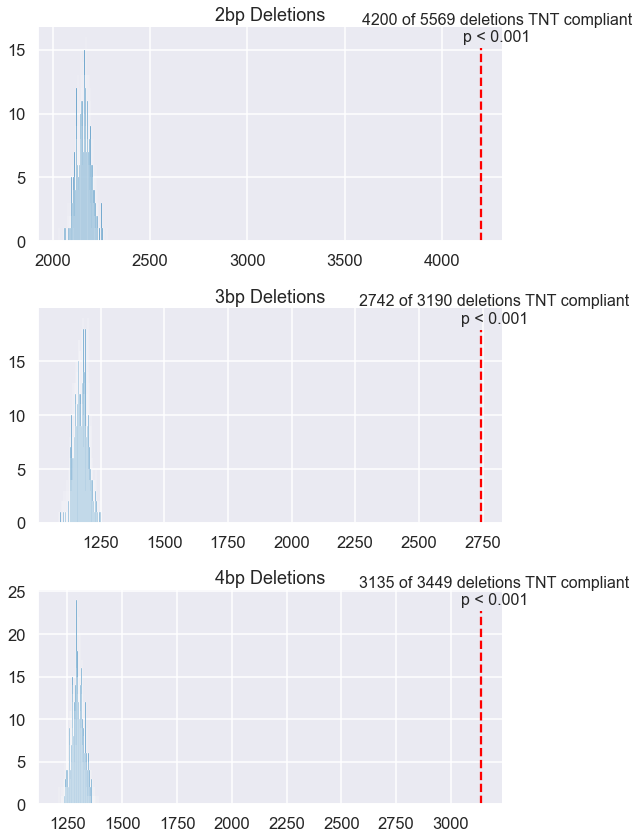

In [7]:
# histograms of samplings from genome
tmp_df = g4d_vs_genome_del_tnt_counts[
    (g4d_vs_genome_del_tnt_counts.TNT_compliant == True) &
    (g4d_vs_genome_del_tnt_counts.Cohort == 'Genome')]

g = sns.FacetGrid(
    data=tmp_df,
    row='variant_length',
    sharex=False,
    sharey=False,
    aspect=2.3,
    height=4,
    hue='Cohort')

g.map_dataframe(
    sns.histplot,
    binwidth=1,
    x='Count',
    kde=False)

# for each grouping, mark the number of TNT compliant deletions observed in Gene4Denovo dataset 
for ax in g.axes.flatten():
    title = ax.get_title()
    filter1 = title.split('|')[0].split()
    ax.set_title('{}bp Deletions'.format(filter1[2]))
    xs = g4d_vs_genome_del_tnt_counts[
        (g4d_vs_genome_del_tnt_counts.Cohort != 'Genome') &
        (g4d_vs_genome_del_tnt_counts.TNT_compliant == True) &
        (g4d_vs_genome_del_tnt_counts[filter1[0]] == int(filter1[2]))
    ].Count.values
    total = g4d_vs_genome_del_tnt_counts[
        (g4d_vs_genome_del_tnt_counts.Cohort != 'Genome') &
        (g4d_vs_genome_del_tnt_counts[filter1[0]] == int(filter1[2]))
    ].Count.sum()
    ylim = ax.get_ylim()
    counts = tmp_df[tmp_df[filter1[0]] == int(filter1[2])].Count.value_counts()
    for x in xs:
        lbl = "{} of {} deletions TNT compliant\n".format(x, total)
        mean = (counts.index.to_numpy() * counts).sum()/ counts.sum()
        d = abs(x - mean)
        u = mean + d
        l = mean - d
        n = counts[(counts.index >= u) | (counts.index <= l)].sum()
        if n > 0:
            p = n/counts.sum()
            lbl += 'p = {:.3f}'.format(p)
        else:
            lbl += 'p < {:.3f}'.format(1/counts.sum())

        ax.plot([x, x], [0, ylim[1] * 0.9], '--', c='r')
        ax.text(x * 1.02, ylim[1] * 0.93, lbl, horizontalalignment='center', size=16)
plt.tight_layout()
plt.savefig(
    os.path.join(out_dir,
                 'g4d_matched_indel_genome_tnt_sampling_hist.pdf')
)

## Resample deletions at repeats to generate null expectation of TNT compliance for deletions at SSTRs/microhomology 

Randomly resample an equal number of >1 bp deletions as observed in gene4denovo
from the mappable genome matching deletion length and repeat category

## Retrieve all 2-5bp SSTRs and microhomology from human genome

In [8]:
grch37_counts = read_rpt_files(glob.glob('data/genome_scans/rpt_counts/grch37*'))
grch37_counts

repeat_type  repeat_length repeat_unit    Count  variant_length  \
0       Imperfect              6       AAAAA  3179155               5   
1       Imperfect              6       AAAAC  1588680               5   
2       Imperfect              6       AAAAG  1439898               5   
3       Imperfect              6       AAAAT  2479399               5   
4       Imperfect              6       AAACA  1188518               5   
...           ...            ...         ...      ...             ...   
29960     Perfect             82        TCCT        1               4   
29961     Perfect             88        CCTT        1               4   
29962     Perfect             95        CTTT        1               4   
29963     Perfect             95        GAGA        1               4   
29964     Perfect             96        GAGA        1               4   

      variant_type repeat_length_cat  N_repeats  TNT_compliant  total_bp  
0              Del                >4          1           True  19074930  
1              Del                >4          1           True   9532080  
2              Del                >4          1           True   8639388  
3              Del                >4          1           True  14876394  
4              Del                >4          1           True   7131108  
...            ...               ...        ...            ...       ...  
29960          Del                >4         19           True        82  
29961          Del                >4         21           True        88  
29962          Del                >4         22           True        95  
29963          Del                >4         22           True        95  
29964          Del                >4         23           True        96  

[29965 rows x 10 columns]

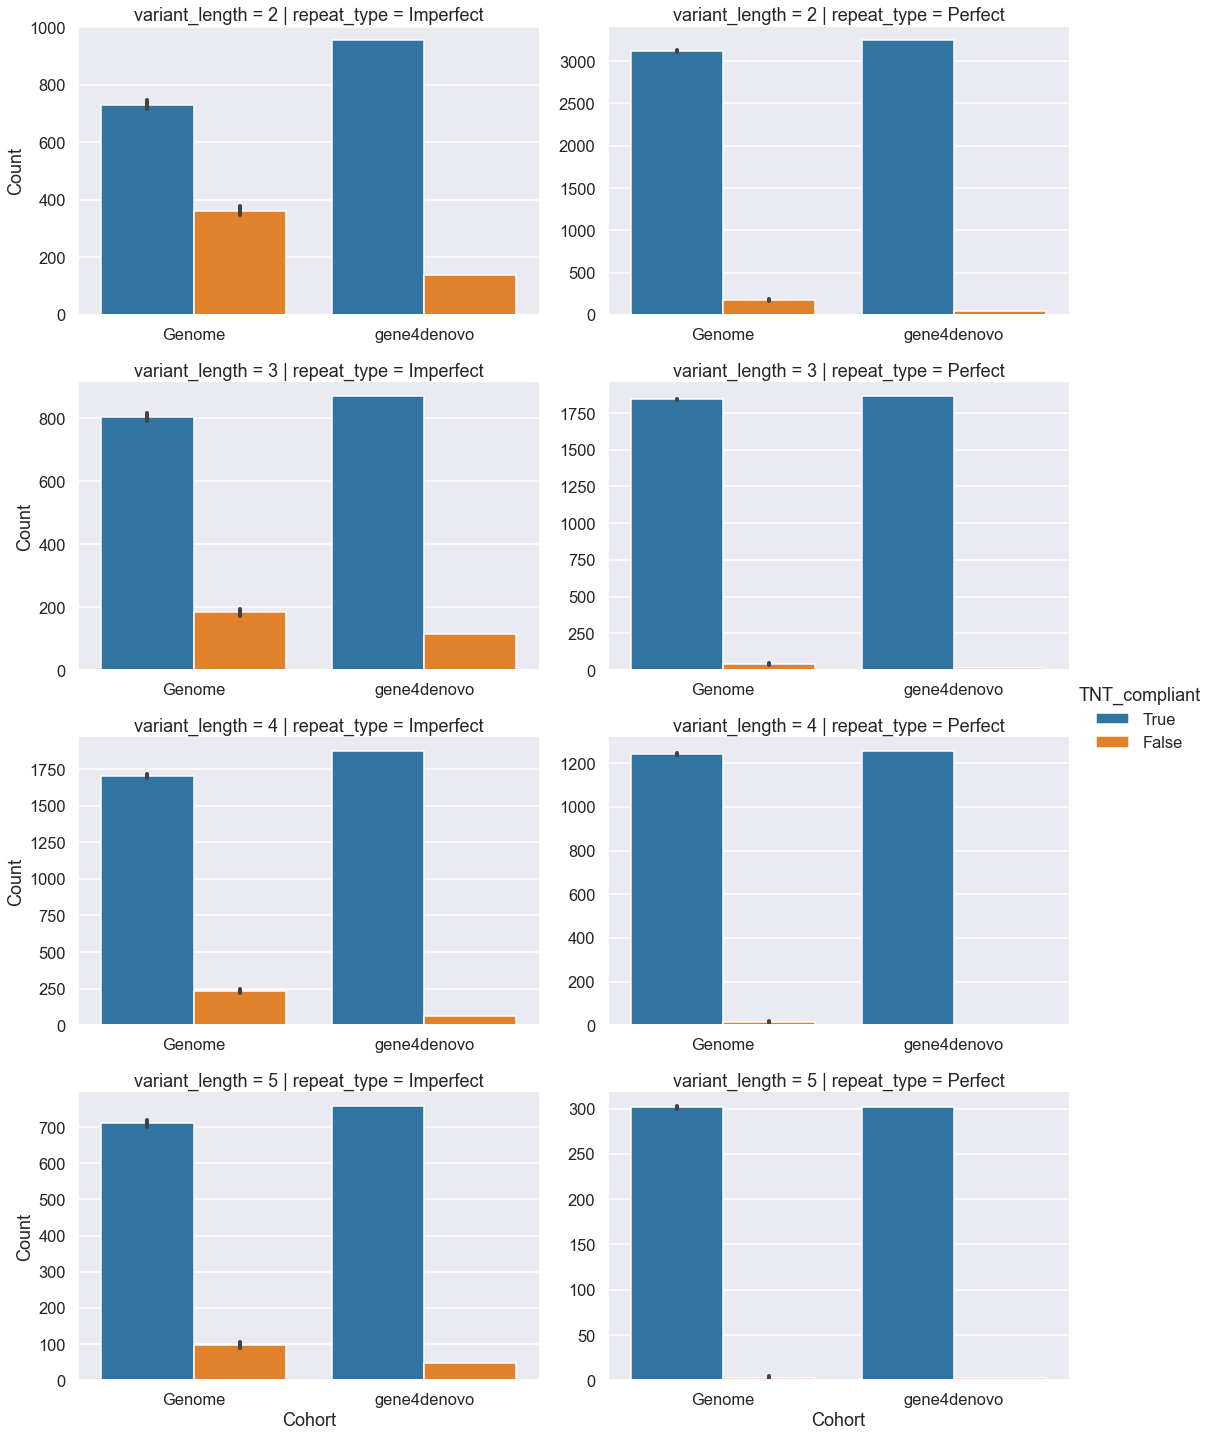

In [9]:
grch37_g4d_sample = resample_from_genome(g4d_deletions, grch37_counts,
                                         n=1000, cohort_name='gene4denovo')
grch37_g4d_sample.to_csv(os.path.join(out_dir,
                                      'tnt_compliance_per_repeat_category.csv'),
                         index=False)

## For each deletion length, plot the number of TNT compliant repeats from each random sample from the genome and mark the number observed in the Gene4Denovo dataset

Given 1000 bootstrap samples, if the number of observed TNT compliant deletions lie outside this distribution this suggests an empirical p-value < 0.001

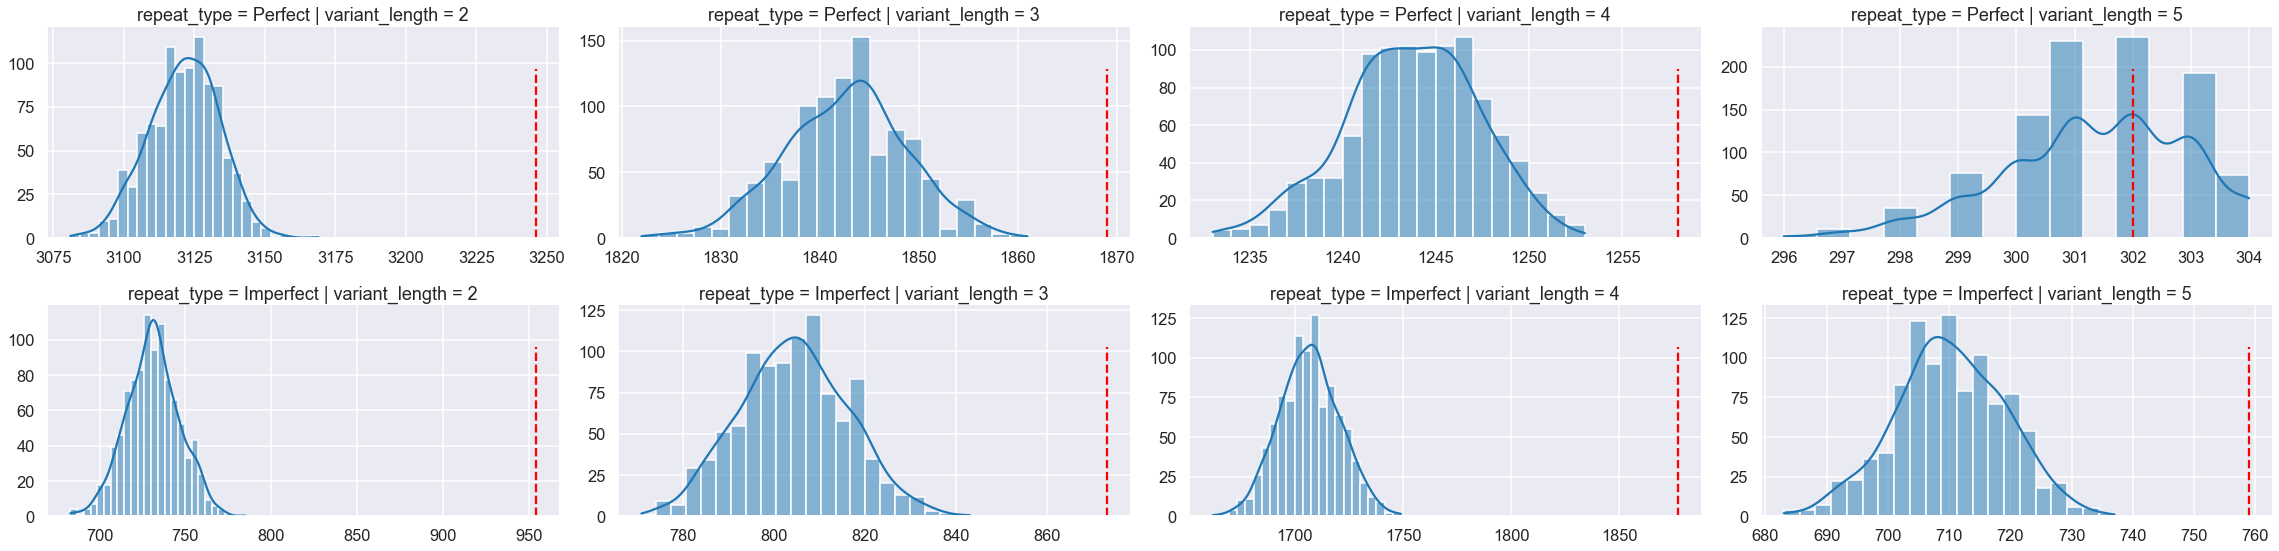

In [10]:
# histograms of samplings from genome
g = sns.FacetGrid(
    data=grch37_g4d_sample[(grch37_g4d_sample.TNT_compliant == True) &
                           (grch37_g4d_sample.Cohort == 'Genome')],
    row='repeat_type',
    row_order=['Perfect', 'Imperfect'],
    col='variant_length',
    sharex=False,
    sharey=False,
    aspect=2,
    height=4,
    hue='Cohort')

g.map_dataframe(
    sns.histplot,
    x='Count',
    kde=True)

# for each grouping, mark the number of TNT compliant deletions observed in Gene4Denovo dataset 
for ax in g.axes.flatten():
    title = ax.get_title()
    filter1 = title.split('|')[0].split()
    filter2 = title.split('|')[1].split()
    xs = grch37_g4d_sample[(grch37_g4d_sample.Cohort == 'gene4denovo') &
                           (grch37_g4d_sample.TNT_compliant == True) &
                           (grch37_g4d_sample[filter1[0]] == filter1[2]) &
                           (grch37_g4d_sample[filter2[0]] == int(filter2[2]))].Count.values
    ylim = ax.get_ylim()
    for x in xs:
        ax.plot([x, x], [0, ylim[1] * 0.8], '--', c='r')
plt.savefig(os.path.join(out_dir, 'g4d_tnt_compliance_per_repeat_category.pdf'))

# rnh201Δ pol2-M644G yeast TNT motif analysis in 2-5 bp deletions

## Resample deletions to generate null expectation of TNT compliance if likelihood at being at a repeat is random

Randomly sample deletions in the mappable genome of the same lengths observed in Gene4Denovo

In [11]:
pol2_M664G_indel_df = pd.read_csv(
    "data/pol2_m644g_rnh201_delta_yeast/pol2_M644G_rnh201_dnms.indels.csv")
pol2_M664G_dels = pol2_M664G_indel_df[pol2_M664G_indel_df.variant_type == 'Del'].copy()
pol2_M664G_dels = pol2_M664G_indel_df[
    (pol2_M664G_indel_df.variant_type == 'Del') &
    (pol2_M664G_indel_df.variant_length > 1)].copy()
pol2_M664G_dels['TNT_compliant'] = pol2_M664G_dels.apply(
    tnt_compliance_from_row,
    axis=1)

In [12]:
gse_fasta_path = "ref/GSE56939_L03_ref_v2/GSE56939_L03_ref_v2.fa"
gse_fa = Fasta(gse_fasta_path, as_raw=True, sequence_always_upper=True)
gse_bed = "ref/GSE56939_L03_ref_v2/GSE56939_L03_ref_v2.bed"
with open(gse_bed, 'wt') as bed_fh:
    for chrom, seq in gse_fa.items():
        bed_fh.write("{}\t{}\t{}\n".format(chrom, 0, seq.unpadded_len))
gse_sampler = IntervalSampler(BedParser(gse_bed))

In [13]:
pol2_M664G_rnh201_vs_genome_del_tnt_counts = compare_deletion_genome_tnt_counts(
    gse_fa,
    gse_sampler,
    pol2_M664G_dels[(pol2_M664G_dels.variant_length > 1) &
                    (pol2_M664G_dels.variant_length < 5)],
    "pol2-M644G rnh201Δ",
    n_samples=10_000)
pol2_M664G_rnh201_vs_genome_del_tnt_counts

Finished sample 1 of 10,000
Finished sample 1,001 of 10,000
Finished sample 2,001 of 10,000
Finished sample 3,001 of 10,000
Finished sample 4,001 of 10,000
Finished sample 5,001 of 10,000
Finished sample 6,001 of 10,000
Finished sample 7,001 of 10,000
Finished sample 8,001 of 10,000
Finished sample 9,001 of 10,000
Finished 10,000 samplings


TNT_compliant  variant_length  Count    Percent  Percent_per_del_length  \
0           False               2     63  50.000000               67.021277   
1           False               3     18  14.285714               75.000000   
2           False               4      7   5.555556               87.500000   
3            True               2     31  24.603175               32.978723   
4            True               3      6   4.761905               25.000000   
..            ...             ...    ...        ...                     ...   
0           False               2      3   2.380952                3.191489   
1           False               3      4   3.174603               16.666667   
2            True               2     91  72.222222               96.808511   
3            True               3     20  15.873016               83.333333   
4            True               4      8   6.349206              100.000000   

                Cohort  
0               Genome  
1               Genome  
2               Genome  
3               Genome  
4               Genome  
..                 ...  
0   pol2-M644G rnh201Δ  
1   pol2-M644G rnh201Δ  
2   pol2-M644G rnh201Δ  
3   pol2-M644G rnh201Δ  
4   pol2-M644G rnh201Δ  

[59772 rows x 6 columns]

In [14]:
pol2_M664G_rnh201_vs_genome_del_tnt_counts.to_csv(
    os.path.join(out_dir,
                 'pol2_M644G_rnh201_matched_indel_genome_tnt_sampling.csv'),
    index=False)

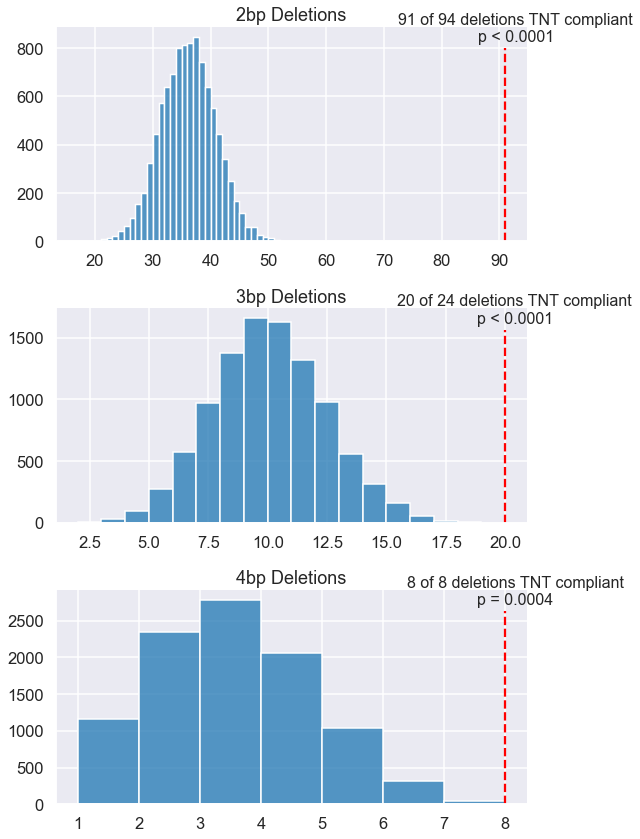

In [15]:
# histograms of samplings from genome
tmp_df = pol2_M664G_rnh201_vs_genome_del_tnt_counts[
    (pol2_M664G_rnh201_vs_genome_del_tnt_counts.TNT_compliant == True) &
    (pol2_M664G_rnh201_vs_genome_del_tnt_counts.Cohort == 'Genome')]

g = sns.FacetGrid(
    data=tmp_df,
    row='variant_length',
    sharex=False,
    sharey=False,
    aspect=2.3,
    height=4,
    hue='Cohort')

g.map_dataframe(
    sns.histplot,
    binwidth=1,
    x='Count',
    kde=False)

# for each grouping, mark the number of TNT compliant deletions observed in Gene4Denovo dataset 
for ax in g.axes.flatten():
    title = ax.get_title()
    filter1 = title.split('|')[0].split()
    ax.set_title('{}bp Deletions'.format(filter1[2]))
    xs = pol2_M664G_rnh201_vs_genome_del_tnt_counts[
        (pol2_M664G_rnh201_vs_genome_del_tnt_counts.Cohort != 'Genome') &
        (pol2_M664G_rnh201_vs_genome_del_tnt_counts.TNT_compliant == True) &
        (pol2_M664G_rnh201_vs_genome_del_tnt_counts[filter1[0]] == int(filter1[2]))
    ].Count.values
    total = pol2_M664G_rnh201_vs_genome_del_tnt_counts[
        (pol2_M664G_rnh201_vs_genome_del_tnt_counts.Cohort != 'Genome') &
        (pol2_M664G_rnh201_vs_genome_del_tnt_counts[filter1[0]] == int(filter1[2]))
    ].Count.sum()
    ylim = ax.get_ylim()
    counts = tmp_df[tmp_df[filter1[0]] == int(filter1[2])].Count.value_counts()
    for x in xs:
        lbl = "{} of {} deletions TNT compliant\n".format(x, total)
        mean = (counts.index.to_numpy() * counts).sum()/ counts.sum()
        d = abs(x - mean)
        u = mean + d
        l = mean - d
        n = counts[(counts.index >= u) | (counts.index <= l)].sum()
        if n > 0:
            p = n/counts.sum()
            lbl += 'p = {:.4f}'.format(p)
        else:
            lbl += 'p < {:.4f}'.format(1/counts.sum())

        ax.plot([x, x], [0, ylim[1] * 0.9], '--', c='r')
        ax.text(x * 1.02, ylim[1] * 0.93, lbl, horizontalalignment='center', size=16)
plt.tight_layout()
plt.savefig(
    os.path.join(out_dir,
                 'pol2_M644G_rnh201_matched_indel_genome_tnt_sampling_hist.pdf')
)

## Resample deletions at repeats to generate null expectation of TNT compliance for deletions at SSTRs/microhomology 

Randomly resample an equal number of >1 bp deletions as observed in yeast
mutation accumulation experiment from the mappable genome matching deletion
length and repeat category

In [16]:
yeast_counts = read_rpt_files(glob.glob('data/genome_scans/rpt_counts/GSE56939_L03_ref_v2*'))
yeast_counts

repeat_type  repeat_length repeat_unit  Count  variant_length  \
0      Imperfect              5        AAAA  37154               4   
1      Imperfect              5        AAAC  15101               4   
2      Imperfect              5        AAAG  19699               4   
3      Imperfect              5        AAAT  24475               4   
4      Imperfect              5        AACA  18756               4   
...          ...            ...         ...    ...             ...   
9785     Perfect              9          GT     29               2   
9786     Perfect              9          TA    223               2   
9787     Perfect              9          TC     66               2   
9788     Perfect              9          TG     35               2   
9789     Perfect              9          TT    641               2   

     variant_type repeat_length_cat  N_repeats  TNT_compliant  total_bp  
0             Del                >4          1           True    185770  
1             Del                >4          1           True     75505  
2             Del                >4          1           True     98495  
3             Del                >4          1           True    122375  
4             Del                >4          1           True     93780  
...           ...               ...        ...            ...       ...  
9785          Del                >4          3           True       261  
9786          Del                >4          3           True      2007  
9787          Del                >4          3           True       594  
9788          Del                >4          3           True       315  
9789          Del                >4          3           True      5769  

[9790 rows x 10 columns]

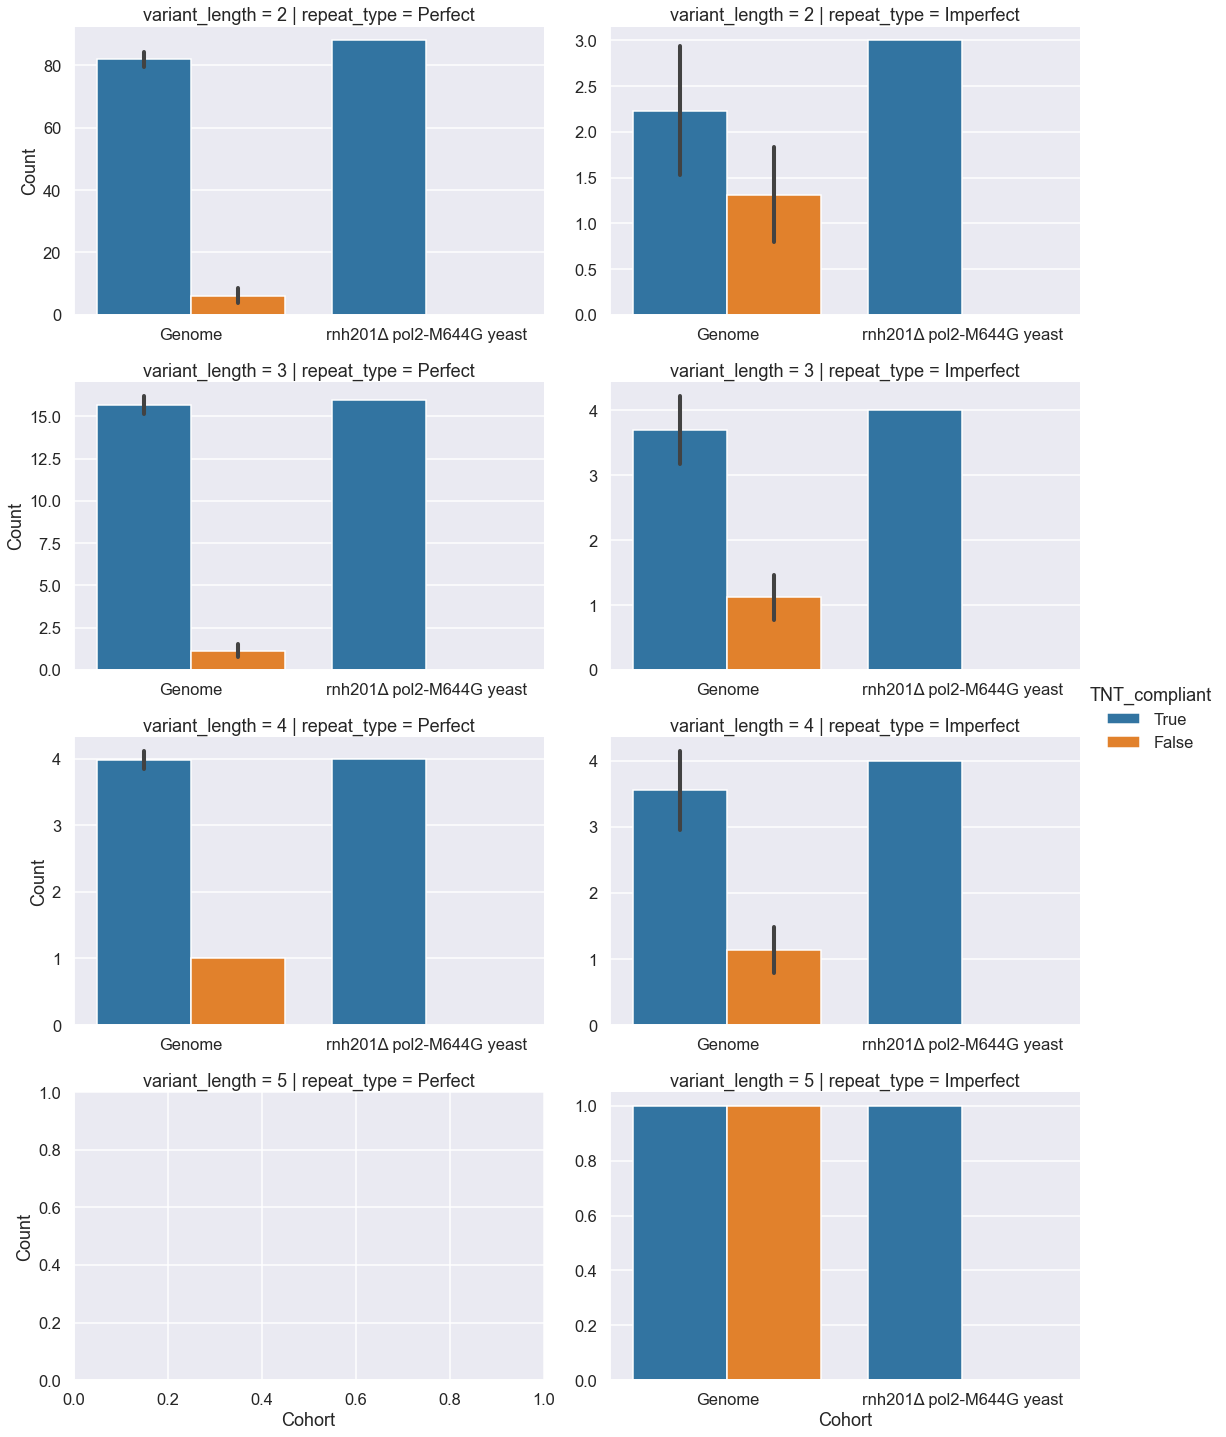

In [19]:
yeast_pol2_sample = resample_from_genome(
    pol2_M664G_dels,
    yeast_counts,
    n=10_000,
    cohort_name='rnh201Δ pol2-M644G yeast')
yeast_pol2_sample.to_csv(
    os.path.join(out_dir,
                 'pol2_M644G_rnh201_tnt_compliance_per_repeat_category.csv'),
    index=False)

Only enough data for 2bp deletions

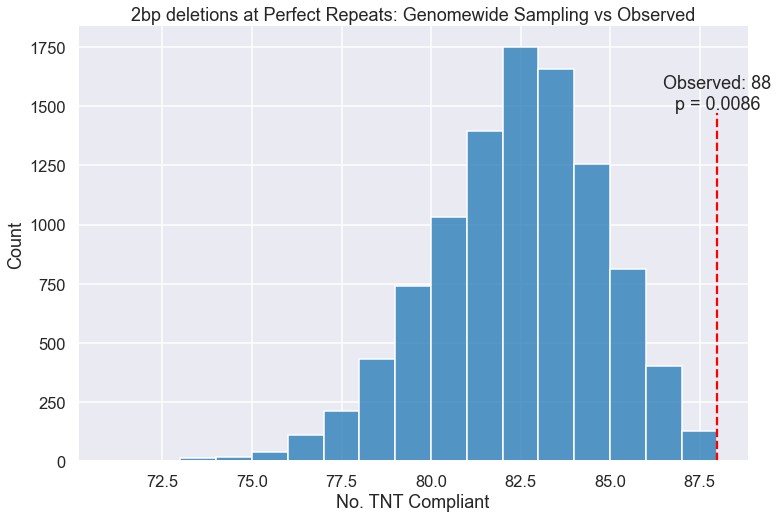

In [20]:
tmp_df = yeast_pol2_sample[(yeast_pol2_sample.TNT_compliant == True) &
                           (yeast_pol2_sample.Cohort == 'Genome') &
                           (yeast_pol2_sample.variant_length == 2) &
                           (yeast_pol2_sample.repeat_type == 'Perfect')]
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=tmp_df,
                  ax=ax,
                  x='Count',
                  binwidth=1,
                  kde=False)

xs = yeast_pol2_sample[(yeast_pol2_sample.Cohort != 'Genome') &
                       (yeast_pol2_sample.TNT_compliant == True) &
                       (yeast_pol2_sample.variant_length == 2) &
                       (yeast_pol2_sample.repeat_type == 'Perfect')].Count.values
ylim = ax.get_ylim()
xlim = ax.get_xlim()
counts = tmp_df.Count.value_counts()
for x in xs:
    ax.plot([x, x], [0, ylim[1] * 0.8], '--', c='r')
    lbl = "Observed: {}\n".format(x)
    mean = (counts.index.to_numpy() * counts).sum()/ counts.sum()
    d = abs(x - mean)
    u = mean + d
    l = mean - d
    n = counts[(counts.index >= u) | (counts.index <= l)].sum()
    if n > 0:
        p = n/counts.sum()
        lbl += 'p = {:g}'.format(p)
    else:
        lbl += 'p < {:g}'.format(1/counts.sum())
    plt.text(x, ylim[1] * 0.8, lbl, horizontalalignment='center', verticalalignment='bottom')
sns.despine()
plt.title("2bp deletions at Perfect Repeats: Genomewide Sampling vs Observed")
plt.xlabel("No. TNT Compliant")
plt.savefig(
    os.path.join(out_dir,
    'pol2_M644G_rnh201_2bp_tnt_compliance_per_repeat_category.pdf'))